In [1]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT,MOVEMENT
import numpy as np
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

device = torch.device("cpu")


In [3]:
actionCount = 0

In [4]:
piece_type_lookup = {
    'Tu': 'T', 'Tr': 'T', 'Td': 'T', 'Tl': 'T',
    'Jl': 'J', 'Ju': 'J', 'Jr': 'J', 'Jd': 'J',
    'Zh': 'Z', 'Zv': 'Z',
    'O': 'O',
    'Sh': 'S', 'Sv': 'S',
    'Lr': 'L', 'Ld': 'L', 'Ll': 'L', 'Lu': 'L',
    'Iv': 'I', 'Ih': 'I',
    'none': 'none'
}

In [5]:
tetris_start_positions = {
    'Tu': (-2, 4),  # Top of 'T' piece, up orientation, centered
    'Tr': (-2, 4),  # Top of 'T' piece, right orientation, centered
    'Td': (-2, 4),  # Top of 'T' piece, down orientation, centered
    'Tl': (-2, 4),  # Top of 'T' piece, left orientation, centered
    'Jl': (-2, 4),  # Top of 'J' piece, left orientation, centered
    'Ju': (-2, 4),  # Top of 'J' piece, up orientation, centered
    'Jr': (-2, 4),  # Top of 'J' piece, right orientation, centered
    'Jd': (-2, 4),  # Top of 'J' piece, down orientation, centered
    'Zh': (-2, 4),  # Top of 'Z' piece, horizontal orientation, centered
    'Zv': (-2, 4),  # Top of 'Z' piece, vertical orientation, centered
    'O':  (-2, 4),  # Top of 'O' piece, centered
    'Sh': (-2, 4),  # Top of 'S' piece, horizontal orientation, centered
    'Sv': (-2, 4),  # Top of 'S' piece, vertical orientation, centered
    'Lr': (-2, 4),  # Top of 'L' piece, right orientation, centered
    'Ld': (-2, 4),  # Top of 'L' piece, down orientation, centered
    'Ll': (-2, 4),  # Top of 'L' piece, left orientation, centered
    'Lu': (-2, 4),  # Top of 'L' piece, up orientation, centered
    # Top of 'I' piece, vertical orientation, slightly left centered to fit 4 blocks
    'Iv': (-4, 3),
    # Top of 'I' piece, horizontal orientation, slightly left centered to fit 4 blocks
    'Ih': (-1, 3)
}

In [6]:
def calculate_heights(grid):
    # This function finds the height of each column in the grid.
    # It calculates height from the bottom to the first non-zero cell encountered from the top.
    heights = np.zeros(grid.shape[1], dtype=int)
    for col in range(grid.shape[1]):
        column = grid[:, col]  # Extract the entire column
        first_filled = np.where(column > 0)[0]
        if first_filled.size > 0:
            heights[col] = grid.shape[0] - first_filled.min()
    return heights

In [7]:
def statePreprocess(state):
    #the shape of the play area is from 48 to 208 in the x direction and 96 to 176 in the y direction
    state = state[48:208,96:176]
    grayscale = np.dot(state[...,:3], [0.2989, 0.5870, 0.1140])
    binary_array = grayscale.reshape(20,8,10,8).max(axis=(1,3)) > 0
    return binary_array.astype(int)

In [8]:
def one_hot_piece(piece):
    # Extended mapping to include variations like 'Td', 'Ld', etc.
    mapping = {
    'Tu': 0,
    'Tr': 1,
    'Td': 2,
    'Tl': 3,
    'Jl': 4,
    'Ju': 5,
    'Jr': 6,
    'Jd': 7,
    'Zh': 8,
    'Zv': 9,
    'O': 10,
    'Sh': 11,
    'Sv': 12,
    'Lr': 13,
    'Ld': 14,
    'Ll': 15,
    'Lu': 16,
    'Iv': 17,
    'Ih': 18,}
    vector = [0] * len(mapping)
    if piece in mapping:  # Check if the piece is recognized
        vector[mapping[piece]] = 1
    else:
        print('Piece not recognized:', piece)
    return vector

In [9]:
def count_covered_voids(board):
    """
    Count the number of empty cells that are vertically covered by a full cell in a Tetris board,
    extending the count to any empty cell directly below a full cell until another full cell or the bottom is reached.

    :param board: 2D numpy array representing the Tetris board, where 1 is a full cell and 0 is empty.
    :return: Integer count of covered voids.
    """
    covered_voids = 0
    rows, cols = board.shape

    # Iterate over each column
    for c in range(cols):
        # Track if we are currently above a full cell
        block_found = False
        for r in range(rows):
            if board[r, c] == 1:
                block_found = True
            elif board[r, c] == 0 and block_found:
                covered_voids += 1

    return covered_voids


In [10]:
def calculate_reward(clearLines,fixState):
    C = 1000
    alpha = 2
    beta = 1
    detla = 3
    heightDiff = calculate_heights(fixState)
    #calculate the highest and second highest difference
    difference = np.max(heightDiff) - np.partition(heightDiff, -2)[-2]
    #calculate the number of holes
    holes = count_covered_voids(fixState)
    reward = C * clearLines - alpha * heightDiff.max() - beta * holes - detla * difference

    return reward

In [11]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.fc = nn.Linear(128, output_dim)
        
        self._create_weights()
        
    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        x = self.fc(x)

        return x

In [12]:
def inputData(heightDiff, current_piece):
    heightDiff = heightDiff.reshape(-1).astype(float)

    # One-hot encode the current and next pieces
    current_piece_vector = one_hot_piece(current_piece)

    # Combine the flattened grid and the piece vectors into one state vector
    return torch.tensor(np.concatenate([heightDiff, current_piece_vector]), dtype=torch.float32)

In [13]:
# def inputData(heightDiff, current_piece, next_piece):
#     heightDiff = heightDiff.reshape(-1).astype(float)

#     # One-hot encode the current and next pieces
#     current_piece_vector = one_hot_piece(current_piece)
#     next_piece_vector = one_hot_piece(next_piece)

#     # Combine the flattened grid and the piece vectors into one state vector
#     return torch.tensor(np.concatenate([heightDiff, current_piece_vector, next_piece_vector]), dtype=torch.float32)

In [14]:
def merge_states(old_state, new_state, old_info, new_info):
    """
    Merge old_state and new_state based on piece transitions.

    Args:
    old_state (array): The previous state of the environment.
    new_state (array): The current state of the environment after taking an action.
    old_info (dict): Information about the previous state (e.g., 'current_piece', 'next_piece').
    new_info (dict): Information about the current state.

    Returns:
    np.array: The merged state where both states are combined appropriately.
    """
    default_piece_type = 'none'
    merged_state = np.zeros_like(old_state)
    if (piece_type_lookup.get(old_info['current_piece'], default_piece_type) != 
        piece_type_lookup.get(new_info['current_piece'], default_piece_type) or
        piece_type_lookup.get(old_info['next_piece'], default_piece_type) != 
        piece_type_lookup.get(new_info['next_piece'], default_piece_type)):

        if old_info['current_piece'] != 'none':
            prev_piece = old_info['current_piece']
            start_row, start_col = tetris_start_positions[prev_piece]

            piece_array = np.zeros_like(old_state)
            for r in range(20):
                for c in range(10):
                    if start_row + r < 0 or start_row + r >= 20 or start_col + c < 0 or start_col + c >= 10:
                        continue
                    if old_state[start_row + r, start_col + c] == 1:
                        old_state[start_row + r, start_col + c] = 0

            merged_state = old_state + new_state
            merged_state[merged_state > 1] = 1
        #plot the merged state
        # plt.imshow(merged_state)
        # plt.show()
        # print(calculate_heights(merged_state), count_covered_voids(merged_state))

    return merged_state

In [15]:
# Initialize the DQN
input_dim = 10 + 19 # 10 for the height difference of the tetris grid, 19 for the one-hot encoded pieces 2 for none piece
output_dim = len(SIMPLE_MOVEMENT)  # Number of possible actions
model = DQN(input_dim, output_dim)
model.to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the replay memory
replay_memory = deque(maxlen = 20000)
batch_size = 128

epsilon = 1.0  # Starting value of epsilon
epsilon_min = 0.01  # Minimum value of epsilon
epsilon_decay = 0.995  # Decay multiplier for epsilon

In [16]:
#number of episodes
episodes = 10000

env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
model.train()

episode_rewards = []

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
default_piece_type = 'no_piece'


/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/Users/furyth666/miniconda3/envs/TetrisRL/lib/python3.10/site-packages/gym/utils/passive_env_c

Episode: 0 Total Reward: 0 Epsilon: 0.995


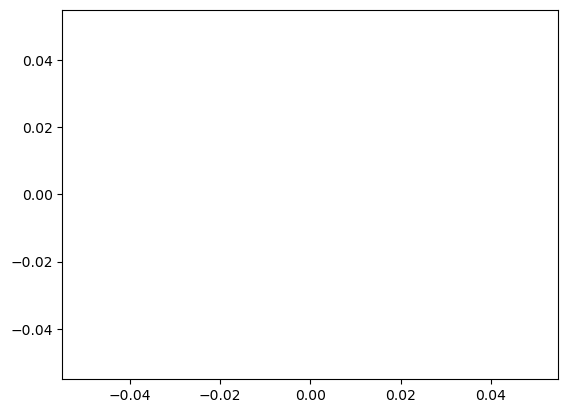

Episode: 1 Total Reward: 0 Epsilon: 0.990025


KeyboardInterrupt: 

In [17]:
rewards= []
for episode in range(episodes):
    env.reset()
    oldState, _, done, oldInfo = env.step(0)
    oldState = statePreprocess(oldState)
    heightDiff = np.zeros((1, 10))
    oldTotalReward = 0
    newInfo = {'current_piece': 'none', 'next_piece': 'none'}
    oldData = inputData(heightDiff-heightDiff.min(), oldInfo['current_piece'])
    mergedState = np.zeros_like(oldState)
    while not done:
        if (oldInfo['current_piece'] is None or oldInfo['next_piece'] is None or 
            newInfo['current_piece'] is None or newInfo['next_piece'] is None):
            break
        # Check if we need to force the first action to be '0' for a new piece
        if (piece_type_lookup.get(oldInfo['current_piece'], default_piece_type) != piece_type_lookup.get(newInfo['current_piece'], default_piece_type) or
            piece_type_lookup.get(oldInfo['next_piece'], default_piece_type) != piece_type_lookup.get(newInfo['next_piece'], default_piece_type)):
            action = 0# Force first action to be '0' when a new piece is detected
        elif random.random() < epsilon:
            action = env.action_space.sample() # Choose a random action
        else:
            with torch.no_grad():
                input = oldData # Get the input tensor
                q_values = model(input) # Get the Q-values
                action = random.choice(range(output_dim))#torch.argmax(q_values).item()  # Choose the action with the highest Q-value
        newState, reward, done, newInfo = env.step(action)
        #env.render()
        newState = statePreprocess(newState)
        mergedState = merge_states(oldState, newState, oldInfo, newInfo)
        heightDiff = calculate_heights(mergedState)
        
        newData = inputData(heightDiff-heightDiff.min(), oldInfo['current_piece'])
        newTotalReward = calculate_reward(newInfo['number_of_lines'], mergedState)
        reward = newTotalReward - oldTotalReward
        
        replay_memory.append((torch.tensor(newData, dtype=torch.float), torch.tensor(action, dtype=torch.long), torch.tensor(
            reward, dtype=torch.float), torch.tensor(oldData, dtype=torch.float), torch.tensor(done, dtype=torch.float)))
        
        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)
            data_batch, action_batch, reward_batch, next_state_batch, done_batch = map(torch.stack, zip(*batch))
            
            q_values = model(data_batch)
            with torch.no_grad():
                next_q_values = model(next_state_batch)
            target_q_values = reward_batch + 0.99 * torch.max(next_q_values, dim=1)[0] * (1 - done_batch)
            loss = loss_fn(q_values[range(batch_size), action_batch], target_q_values)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
    
        oldInfo = newInfo
        oldState = newState
        oldTotalReward = newTotalReward
        oldData = newData
        
        if done:
            break
    rewards.append(oldTotalReward)
    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    print('Episode:', episode, 'Total Reward:', oldTotalReward, 'Epsilon:', epsilon)
    #plotting the rewards every 30 episodes
    if episode % 30 == 0:
        plt.plot(rewards)
        plt.show()
        
        
        
        
    
